***EXPERIMENT SETUP***

- percentages_set_1 = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- lr pretraining = 0.001
- lr finetuning = 0.0001

- architecture:
    - Conv 1 (5,5), channels=1
    - Relu
    - Conv 2 (5,5,), channels=1
    - Relu
    - Pooling: TRUE
    - dense( x, x) x=output shape of prev layer (128?)
    - Relu
    - dense(x, 5)
    - softmax
    
- Freezing: NO

- Reinitializing CNN layers: No
- Reinitializing CNN layers: No
- Reinitializing softmax layers: Yes

- If we don’t save the best model, ES=6

- num train = 20

***IMPORTS***

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from types import SimpleNamespace

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

***UTILS***

In [4]:
def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):

    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

In [5]:
class Trainer:

    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """


    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params

        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0

        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)
        
    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):

          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])

          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
            self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

In [6]:
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

In [7]:
class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

In [8]:
class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=4):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [10]:
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=False):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)
        
      # Save the flattened size for reinitializing layers later
      self.flattened_size = x.shape[1]

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

In [11]:
def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=False):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

***PRE-TRAINING***

In [12]:
batch_size = 128

dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

100%|██████████| 9912422/9912422 [00:00<00:00, 88255409.32it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46358857.18it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26503862.58it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13865013.66it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



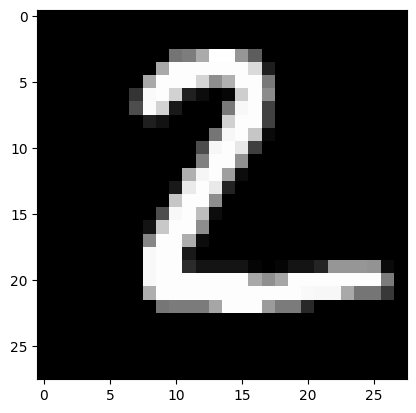

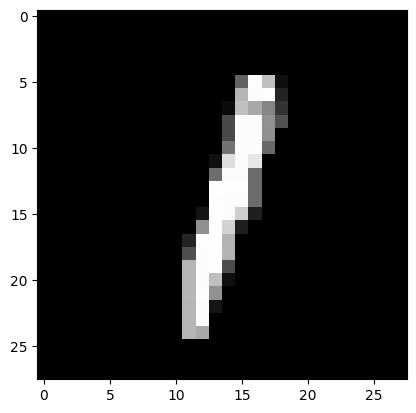

In [13]:
a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        break

In [14]:
params = {
      'depth': 2,
      'width': 1,
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': False
    }

# Create DNN model
model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [15]:
model

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [16]:
# Train and evaluate
trainer = Trainer(model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Batch: 0, Loss: 2.2946743965148926
Batch: 20, Loss: 1.3385170698165894
Batch: 40, Loss: 0.4751957058906555
Batch: 60, Loss: 0.1860802322626114
Batch: 80, Loss: 0.15321165323257446
Batch: 100, Loss: 0.12721547484397888
Batch: 120, Loss: 0.13916543126106262
Batch: 140, Loss: 0.24418886005878448
Batch: 160, Loss: 0.1439710110425949
Batch: 180, Loss: 0.11715759336948395
Batch: 200, Loss: 0.1659645289182663

Average loss: 0.1312, Accuracy: 26420.0/27537 (96%)


Average loss: 0.1535, Accuracy: 2903.0/3059 (95%)

Epoch: 0 	Training Accuracy: 95.94%
Validation Accuracy: 94.90%
Batch: 0, Loss: 0.1366705596446991
Batch: 20, Loss: 0.10133597999811172
Batch: 40, Loss: 0.10755718499422073
Batch: 60, Loss: 0.2564704418182373
Batch: 80, Loss: 0.0705508440732956
Batch: 100, Loss: 0.05803706869482994
Batch: 120, Loss: 0.05429243668913841
Batch: 140, Loss: 0.15856555104255676
Batch: 160, Loss: 0.10078997164964676
Batch: 180, Loss: 0.047261931002140045
Batch: 200, Loss: 0.1690939962863922

Average loss: 

In [17]:
accuracy = eval(model, device, dataloader_wrapped.test_loader, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])


Average loss: 0.0695, Accuracy: 5040.0/5139 (98%)



conv0.weight: 4.0413
conv1.weight: 3.2287
fc_1.weight: 59.7336
fc_2.weight: 8.4843


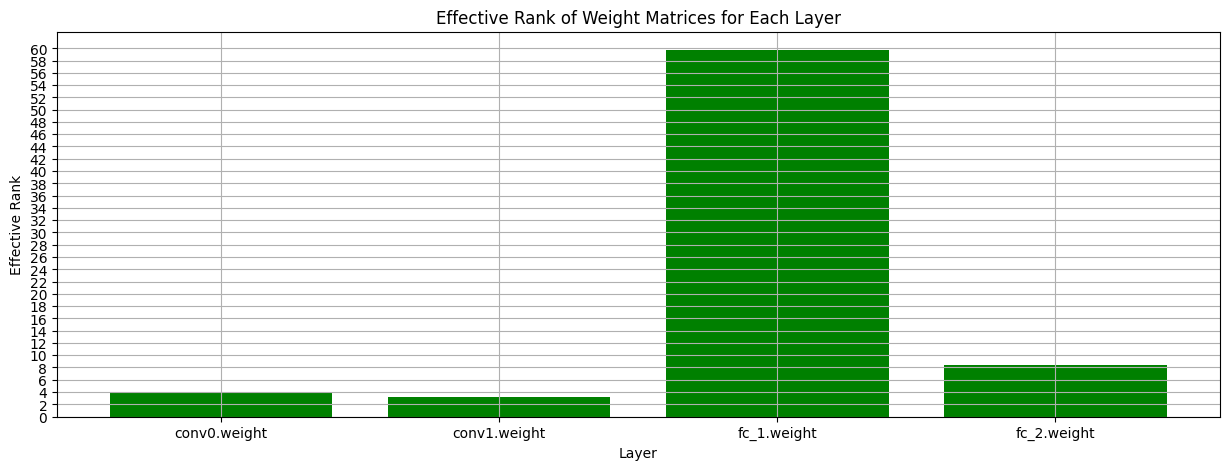

In [18]:
def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

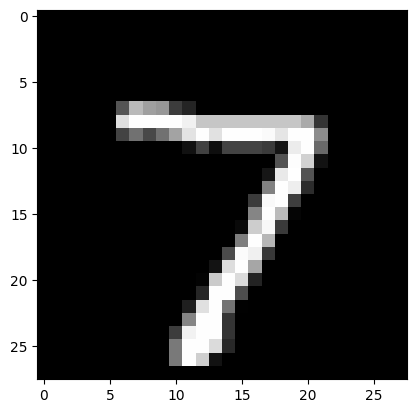

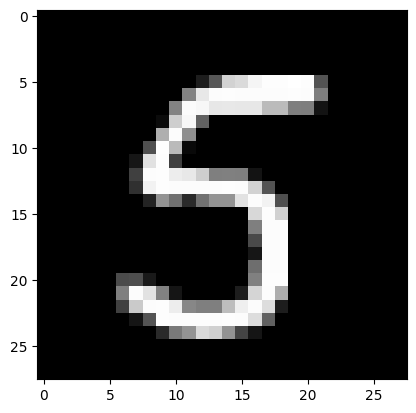

-------------


In [19]:
dataloader_wrapped.update_phase('finetune')

a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [20]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
print("Current dataloader phase: ", dataloader_wrapped.get_current_phase())

model_finetuning_baseline = generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
model_finetuning_baseline.to(device)

# dataloader_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
# train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataloader_wrapped, params, debug=True)

trainer = Trainer(model, dataloader_wrapped, params)
train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Current dataloader phase:  finetune
Batch: 0, Loss: 5.620834827423096
Batch: 20, Loss: 1.4673172235488892
Batch: 40, Loss: 1.0676904916763306
Batch: 60, Loss: 0.8198676109313965
Batch: 80, Loss: 0.5864421725273132
Batch: 100, Loss: 0.5524859428405762
Batch: 120, Loss: 0.4833773970603943
Batch: 140, Loss: 0.38788285851478577
Batch: 160, Loss: 0.4650513529777527
Batch: 180, Loss: 0.2700682580471039
Batch: 200, Loss: 0.4383014142513275

Average loss: 0.3400, Accuracy: 23420.0/26464 (88%)


Average loss: 0.3477, Accuracy: 2590.0/2940 (88%)

Epoch: 0 	Training Accuracy: 88.50%
Validation Accuracy: 88.10%
Batch: 0, Loss: 0.29712235927581787
Batch: 20, Loss: 0.3448997437953949
Batch: 40, Loss: 0.30209168791770935
Batch: 60, Loss: 0.22298786044120789
Batch: 80, Loss: 0.30897191166877747
Batch: 100, Loss: 0.20854678750038147
Batch: 120, Loss: 0.2126522809267044
Batch: 140, Loss: 0.3285782039165497
Batch: 160, Loss: 0.3588930368423462
Batch: 180, Loss: 0.1416746824979782
Batch: 200, Loss: 0.2117

conv0.weight: 3.8735
conv1.weight: 4.2903
fc_1.weight: 124.1394
fc_2.weight: 4.9787


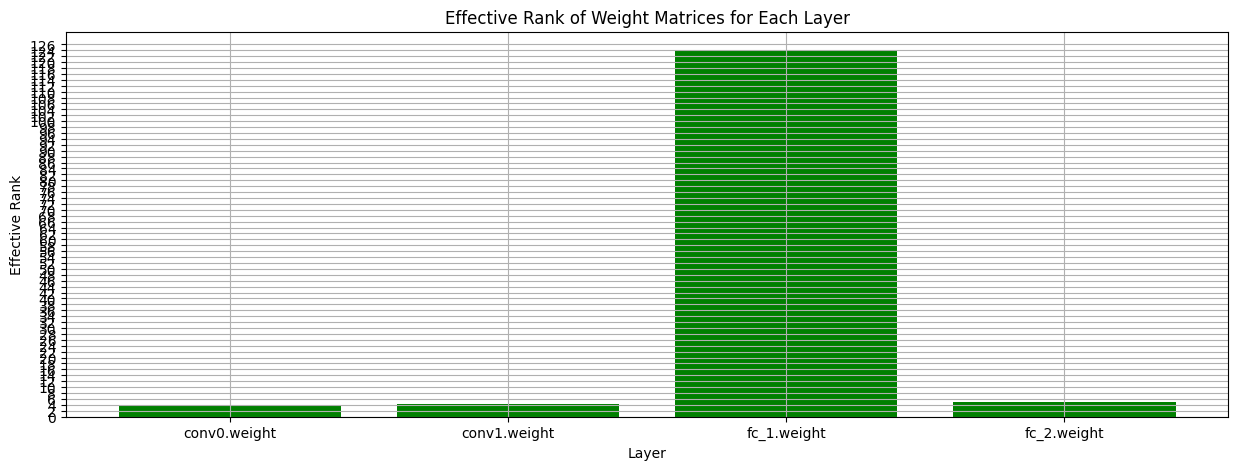

In [21]:
plot_layer_effective_ranks(model_finetuning_baseline)

***WITH BALANCED CLASSES***

Training with different data percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Training for data percentage: 0.01:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 29 =========================
Batch: 0, Loss: 1.6062769889831543

Average loss: 1.5751, Accuracy: 76.0/260 (29%)


Average loss: 1.5812, Accuracy: 792.0/2940 (27%)

Epoch: 0 	Training Accuracy: 29.23%
Validation Accuracy: 26.94%
Batch: 0, Loss: 1.5752042531967163

Average loss: 1.5431, Accuracy: 151.0/260 (58%)


Average loss: 1.5534, Accuracy: 1563.0/2940 (53%)

Epoch: 1 	Training Accuracy: 58.08%
Validation Accuracy: 53.16%
Batch: 0, Loss: 1.5437633991241455

Average loss: 1.5073, Accuracy: 166.0/260 (64%)


Average loss: 1.5228, Accuracy: 1645.0/2940 (56%)

Epoch: 2 	Training Accuracy: 63.85%
Validation Accuracy: 55

Training for data percentage: 0.03:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 16 =========================
Batch: 0, Loss: 1.613884687423706

Average loss: 1.5611, Accuracy: 357.0/790 (45%)


Average loss: 1.5635, Accuracy: 1391.0/2940 (47%)

Epoch: 0 	Training Accuracy: 45.19%
Validation Accuracy: 47.31%
Batch: 0, Loss: 1.5604032278060913

Average loss: 1.4381, Accuracy: 504.0/790 (64%)


Average loss: 1.4487, Accuracy: 1922.0/2940 (65%)

Epoch: 1 	Training Accuracy: 63.80%
Validation Accuracy: 65.37%
Batch: 0, Loss: 1.4266177415847778

Average loss: 1.2059, Accuracy: 555.0/790 (70%)


Average loss: 1.2293, Accuracy: 2075.0/2940 (71%)

Epoch: 2 	Training Accuracy: 70.25%
Validation Accuracy: 7

Training for data percentage: 0.05:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 92 =========================
Batch: 0, Loss: 1.6009979248046875

Average loss: 1.6077, Accuracy: 264.0/1320 (20%)


Average loss: 1.6072, Accuracy: 656.0/2940 (22%)

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 22.31%
Batch: 0, Loss: 1.6076853275299072

Average loss: 1.5855, Accuracy: 592.0/1320 (45%)


Average loss: 1.5855, Accuracy: 1359.0/2940 (46%)

Epoch: 1 	Training Accuracy: 44.85%
Validation Accuracy: 46.22%
Batch: 0, Loss: 1.5826796293258667

Average loss: 1.4765, Accuracy: 716.0/1320 (54%)


Average loss: 1.4797, Accuracy: 1579.0/2940 (54%)

Epoch: 2 	Training Accuracy: 54.24%
Validation Accuracy

Training for data percentage: 0.1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 59 =========================
Batch: 0, Loss: 1.608091950416565
Batch: 20, Loss: 1.3088747262954712

Average loss: 1.3086, Accuracy: 1985.0/2645 (75%)


Average loss: 1.3074, Accuracy: 2204.0/2940 (75%)

Epoch: 0 	Training Accuracy: 75.05%
Validation Accuracy: 74.97%
Batch: 0, Loss: 1.2751109600067139
Batch: 20, Loss: 0.5806070566177368

Average loss: 0.5659, Accuracy: 2148.0/2645 (81%)


Average loss: 0.5570, Accuracy: 2407.0/2940 (82%)

Epoch: 1 	Training Accuracy: 81.21%
Validation Accuracy: 81.87%
Batch: 0, Loss: 0.5811675190925598
Batch: 20, Loss: 0.31403082609176636

Average loss: 0.3769, Accuracy: 2300.0/2645 (8

Training for data percentage: 0.15:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 36 =========================
Batch: 0, Loss: 1.6107004880905151
Batch: 20, Loss: 1.3030699491500854

Average loss: 0.8109, Accuracy: 3076.0/3965 (78%)


Average loss: 0.8321, Accuracy: 2240.0/2940 (76%)

Epoch: 0 	Training Accuracy: 77.58%
Validation Accuracy: 76.19%
Batch: 0, Loss: 0.809802770614624
Batch: 20, Loss: 0.4119061231613159

Average loss: 0.3661, Accuracy: 3436.0/3965 (87%)


Average loss: 0.4051, Accuracy: 2546.0/2940 (87%)

Epoch: 1 	Training Accuracy: 86.66%
Validation Accuracy: 86.60%
Batch: 0, Loss: 0.3050866723060608
Batch: 20, Loss: 0.29491758346557617

Average loss: 0.2795, Accuracy: 3595.0/3965 (9

Training for data percentage: 0.2:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 92 =========================
Batch: 0, Loss: 1.609753966331482
Batch: 20, Loss: 1.5643584728240967
Batch: 40, Loss: 1.180634617805481

Average loss: 1.0887, Accuracy: 3812.0/5290 (72%)


Average loss: 1.0854, Accuracy: 2146.0/2940 (73%)

Epoch: 0 	Training Accuracy: 72.06%
Validation Accuracy: 72.99%
Batch: 0, Loss: 1.0376838445663452
Batch: 20, Loss: 0.3758104741573334
Batch: 40, Loss: 0.39911484718322754

Average loss: 0.3940, Accuracy: 4585.0/5290 (87%)


Average loss: 0.4279, Accuracy: 2549.0/2940 (87%)

Epoch: 1 	Training Accuracy: 86.67%
Validation Accuracy: 86.70%
Batch: 0, Loss: 0.3838943839073181
Batch: 20, L

Training for data percentage: 0.4:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 81 =========================
Batch: 0, Loss: 1.6053521633148193
Batch: 20, Loss: 1.0774461030960083
Batch: 40, Loss: 0.4410350024700165
Batch: 60, Loss: 0.3773602247238159
Batch: 80, Loss: 0.2963378131389618

Average loss: 0.2352, Accuracy: 9810.0/10585 (93%)


Average loss: 0.2770, Accuracy: 2722.0/2940 (93%)

Epoch: 0 	Training Accuracy: 92.68%
Validation Accuracy: 92.59%
Batch: 0, Loss: 0.14864587783813477
Batch: 20, Loss: 0.17261552810668945
Batch: 40, Loss: 0.2557668089866638
Batch: 60, Loss: 0.12488699704408646
Batch: 80, Loss: 0.1538309007883072

Average loss: 0.1851, Accuracy: 9940.0/10585 (94%)


Average loss

Training for data percentage: 0.6:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 3 =========================
Batch: 0, Loss: 1.612560510635376
Batch: 20, Loss: 1.5089508295059204
Batch: 40, Loss: 1.0278425216674805
Batch: 60, Loss: 0.6346762776374817
Batch: 80, Loss: 0.5705691576004028
Batch: 100, Loss: 0.3109186887741089
Batch: 120, Loss: 0.2788904905319214

Average loss: 0.3347, Accuracy: 14114.0/15875 (89%)


Average loss: 0.3435, Accuracy: 2601.0/2940 (88%)

Epoch: 0 	Training Accuracy: 88.91%
Validation Accuracy: 88.47%
Batch: 0, Loss: 0.27793437242507935
Batch: 20, Loss: 0.4364601671695709
Batch: 40, Loss: 0.22785019874572754
Batch: 60, Loss: 0.22915758192539215
Batch: 80, Loss: 0.2222283184

Training for data percentage: 0.8:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 66 =========================
Batch: 0, Loss: 1.6153839826583862
Batch: 20, Loss: 1.5241566896438599
Batch: 40, Loss: 0.7096868753433228
Batch: 60, Loss: 0.2934790849685669
Batch: 80, Loss: 0.35868436098098755
Batch: 100, Loss: 0.3371414542198181
Batch: 120, Loss: 0.26838093996047974
Batch: 140, Loss: 0.24230796098709106
Batch: 160, Loss: 0.21030724048614502

Average loss: 0.2400, Accuracy: 19545.0/21170 (92%)


Average loss: 0.2577, Accuracy: 2704.0/2940 (92%)

Epoch: 0 	Training Accuracy: 92.32%
Validation Accuracy: 91.97%
Batch: 0, Loss: 0.2281331717967987
Batch: 20, Loss: 0.23521238565444946
Batch: 40, Loss: 0.2599

Training for data percentage: 1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 96 =========================
Batch: 0, Loss: 1.6140944957733154
Batch: 20, Loss: 0.9034502506256104
Batch: 40, Loss: 0.38944488763809204
Batch: 60, Loss: 0.31907033920288086
Batch: 80, Loss: 0.22760415077209473
Batch: 100, Loss: 0.14661246538162231
Batch: 120, Loss: 0.13097740709781647
Batch: 140, Loss: 0.2736418545246124
Batch: 160, Loss: 0.14347133040428162
Batch: 180, Loss: 0.2126135677099228
Batch: 200, Loss: 0.18947750329971313

Average loss: 0.1736, Accuracy: 24649.0/26038 (95%)


Average loss: 0.1982, Accuracy: 2765.0/2940 (94%)

Epoch: 0 	Training Accuracy: 94.67%
Validation Accuracy: 94.05%
Batch: 0, Loss: 0.

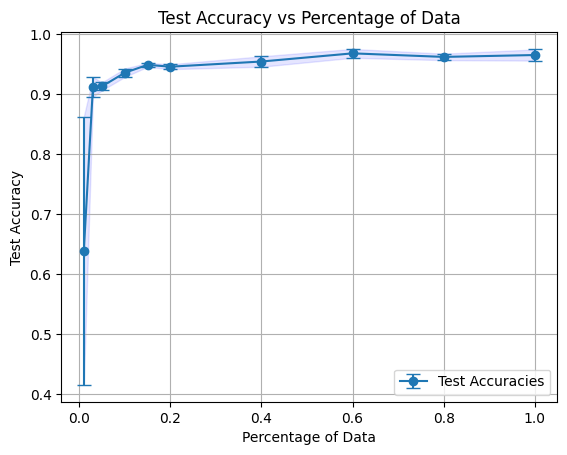

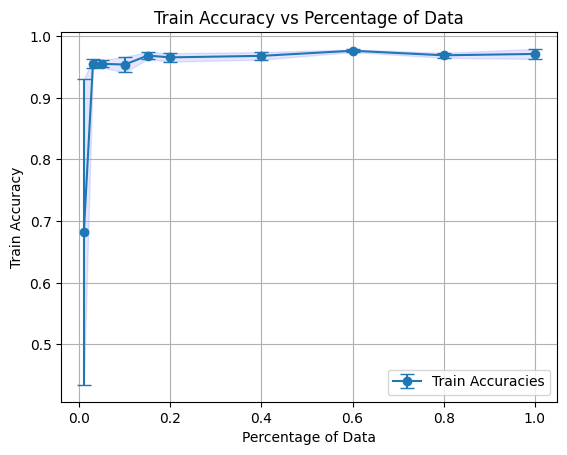

In [22]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01]
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]

seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Training with different data percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []

    for seed in tqdm(seed_set, desc=f'Training for data percentage: {perc}', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        
        model_new =  generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)

        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        # Train and evaluate the new model on the new data
        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        # Add tqdm write method to prevent progress bar overlap
        tqdm.write(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
        tqdm.write(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

## Only heads and data for new classes

now with balanced classes

Processing percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Running seeds for 0.01 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 42 =========================
Batch: 0, Loss: 0.1538412868976593

Average loss: 0.1117, Accuracy: 253.0/260 (97%)


Average loss: 0.1278, Accuracy: 2815.0/2940 (96%)

Epoch: 0 	Training Accuracy: 97.31%
Validation Accuracy: 95.75%
Batch: 0, Loss: 0.09175896644592285

Average loss: 0.1094, Accuracy: 254.0/260 (98%)


Average loss: 0.1282, Accuracy: 2817.0/2940 (96%)

Epoch: 1 	Training Accuracy: 97.69%
Validation Accuracy: 95.82%
Batch: 0, Loss: 0.10135609656572342

Average loss: 0.1071, Accuracy: 254.0/260 (98%)


Average loss: 0.1283, Accuracy: 2816.0/2940 (96%)

Epoch: 2 	Training Accuracy: 97.69%
Validation Accuracy

Running seeds for 0.03 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 48 =========================
Batch: 0, Loss: 0.05139961838722229

Average loss: 0.0567, Accuracy: 776.0/790 (98%)


Average loss: 0.1267, Accuracy: 2821.0/2940 (96%)

Epoch: 0 	Training Accuracy: 98.23%
Validation Accuracy: 95.95%
Batch: 0, Loss: 0.05495882034301758

Average loss: 0.0542, Accuracy: 778.0/790 (98%)


Average loss: 0.1267, Accuracy: 2828.0/2940 (96%)

Epoch: 1 	Training Accuracy: 98.48%
Validation Accuracy: 96.19%
Batch: 0, Loss: 0.05992681533098221

Average loss: 0.0523, Accuracy: 778.0/790 (98%)


Average loss: 0.1270, Accuracy: 2825.0/2940 (96%)

Epoch: 2 	Training Accuracy: 98.48%
Validation Accurac

Running seeds for 0.05 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 4 =========================
Batch: 0, Loss: 0.07561758160591125

Average loss: 0.0847, Accuracy: 1278.0/1320 (97%)


Average loss: 0.1257, Accuracy: 2826.0/2940 (96%)

Epoch: 0 	Training Accuracy: 96.82%
Validation Accuracy: 96.12%
Batch: 0, Loss: 0.053061410784721375

Average loss: 0.0819, Accuracy: 1284.0/1320 (97%)


Average loss: 0.1244, Accuracy: 2825.0/2940 (96%)

Epoch: 1 	Training Accuracy: 97.27%
Validation Accuracy: 96.09%
Batch: 0, Loss: 0.08550422638654709

Average loss: 0.0795, Accuracy: 1285.0/1320 (97%)


Average loss: 0.1238, Accuracy: 2828.0/2940 (96%)

Epoch: 2 	Training Accuracy: 97.35%
Validation A

Running seeds for 0.1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 13 =========================
Batch: 0, Loss: 0.19284094870090485
Batch: 20, Loss: 0.13844533264636993

Average loss: 0.1065, Accuracy: 2563.0/2645 (97%)


Average loss: 0.1256, Accuracy: 2824.0/2940 (96%)

Epoch: 0 	Training Accuracy: 96.90%
Validation Accuracy: 96.05%
Batch: 0, Loss: 0.07928416877985
Batch: 20, Loss: 0.24133408069610596

Average loss: 0.1034, Accuracy: 2563.0/2645 (97%)


Average loss: 0.1239, Accuracy: 2823.0/2940 (96%)

Epoch: 1 	Training Accuracy: 96.90%
Validation Accuracy: 96.02%
Batch: 0, Loss: 0.04732947424054146
Batch: 20, Loss: 0.10009358078241348

Average loss: 0.1012, Accuracy: 2566.0/2645

Running seeds for 0.15 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 45 =========================
Batch: 0, Loss: 0.14837679266929626
Batch: 20, Loss: 0.0756344422698021

Average loss: 0.0860, Accuracy: 3852.0/3965 (97%)


Average loss: 0.1241, Accuracy: 2824.0/2940 (96%)

Epoch: 0 	Training Accuracy: 97.15%
Validation Accuracy: 96.05%
Batch: 0, Loss: 0.05967297405004501
Batch: 20, Loss: 0.11741243302822113

Average loss: 0.0841, Accuracy: 3856.0/3965 (97%)


Average loss: 0.1236, Accuracy: 2830.0/2940 (96%)

Epoch: 1 	Training Accuracy: 97.25%
Validation Accuracy: 96.26%
Batch: 0, Loss: 0.044929713010787964
Batch: 20, Loss: 0.07528393715620041

Average loss: 0.0825, Accuracy: 3860.0/3

Running seeds for 0.2 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 7 =========================
Batch: 0, Loss: 0.1017785593867302
Batch: 20, Loss: 0.1771053522825241
Batch: 40, Loss: 0.11757481843233109

Average loss: 0.0872, Accuracy: 5144.0/5290 (97%)


Average loss: 0.1232, Accuracy: 2827.0/2940 (96%)

Epoch: 0 	Training Accuracy: 97.24%
Validation Accuracy: 96.16%
Batch: 0, Loss: 0.05308317020535469
Batch: 20, Loss: 0.1144079938530922
Batch: 40, Loss: 0.08625926077365875

Average loss: 0.0847, Accuracy: 5144.0/5290 (97%)


Average loss: 0.1223, Accuracy: 2826.0/2940 (96%)

Epoch: 1 	Training Accuracy: 97.24%
Validation Accuracy: 96.12%
Batch: 0, Loss: 0.20773465931415558
Batch: 2

Running seeds for 0.4 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 73 =========================
Batch: 0, Loss: 0.07766793668270111
Batch: 20, Loss: 0.07360903918743134
Batch: 40, Loss: 0.08933797478675842
Batch: 60, Loss: 0.1145893856883049
Batch: 80, Loss: 0.08414718508720398

Average loss: 0.0960, Accuracy: 10257.0/10585 (97%)


Average loss: 0.1237, Accuracy: 2826.0/2940 (96%)

Epoch: 0 	Training Accuracy: 96.90%
Validation Accuracy: 96.12%
Batch: 0, Loss: 0.07066283375024796
Batch: 20, Loss: 0.08091089129447937
Batch: 40, Loss: 0.04130628705024719
Batch: 60, Loss: 0.12034976482391357
Batch: 80, Loss: 0.10256204009056091

Average loss: 0.0942, Accuracy: 10260.0/10585 (97%)


Aver

Running seeds for 0.6 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 35 =========================
Batch: 0, Loss: 0.04952879995107651
Batch: 20, Loss: 0.0589110367000103
Batch: 40, Loss: 0.032580576837062836
Batch: 60, Loss: 0.13507138192653656
Batch: 80, Loss: 0.08134350180625916
Batch: 100, Loss: 0.14677491784095764
Batch: 120, Loss: 0.08215965330600739

Average loss: 0.0909, Accuracy: 15401.0/15875 (97%)


Average loss: 0.1229, Accuracy: 2827.0/2940 (96%)

Epoch: 0 	Training Accuracy: 97.01%
Validation Accuracy: 96.16%
Batch: 0, Loss: 0.1418958604335785
Batch: 20, Loss: 0.07899712026119232
Batch: 40, Loss: 0.1198766678571701
Batch: 60, Loss: 0.11738989502191544
Batch: 80, Loss: 0.09

Running seeds for 0.8 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 31 =========================
Batch: 0, Loss: 0.11676336079835892
Batch: 20, Loss: 0.06568015366792679
Batch: 40, Loss: 0.06796656548976898
Batch: 60, Loss: 0.1388002187013626
Batch: 80, Loss: 0.08232013136148453
Batch: 100, Loss: 0.18831036984920502
Batch: 120, Loss: 0.08162383735179901
Batch: 140, Loss: 0.1331622302532196
Batch: 160, Loss: 0.17932747304439545

Average loss: 0.0933, Accuracy: 20503.0/21170 (97%)


Average loss: 0.1229, Accuracy: 2829.0/2940 (96%)

Epoch: 0 	Training Accuracy: 96.85%
Validation Accuracy: 96.22%
Batch: 0, Loss: 0.09375305473804474
Batch: 20, Loss: 0.17909301817417145
Batch: 40, Loss: 0.

Running seeds for 1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 97 =========================
Batch: 0, Loss: 0.09083220362663269
Batch: 20, Loss: 0.12516753375530243
Batch: 40, Loss: 0.05905267968773842
Batch: 60, Loss: 0.1227249950170517
Batch: 80, Loss: 0.08798424154520035
Batch: 100, Loss: 0.07765374332666397
Batch: 120, Loss: 0.09849219024181366
Batch: 140, Loss: 0.07221851497888565
Batch: 160, Loss: 0.06604713201522827
Batch: 180, Loss: 0.06179041787981987
Batch: 200, Loss: 0.16714830696582794

Average loss: 0.0926, Accuracy: 25246.0/26038 (97%)


Average loss: 0.1213, Accuracy: 2831.0/2940 (96%)

Epoch: 0 	Training Accuracy: 96.96%
Validation Accuracy: 96.29%
Batch: 0, Loss:

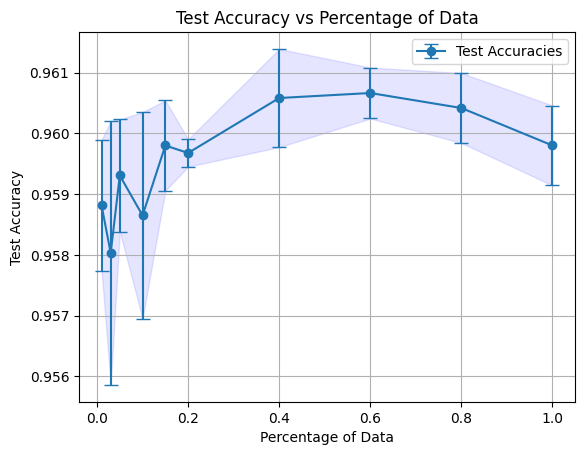

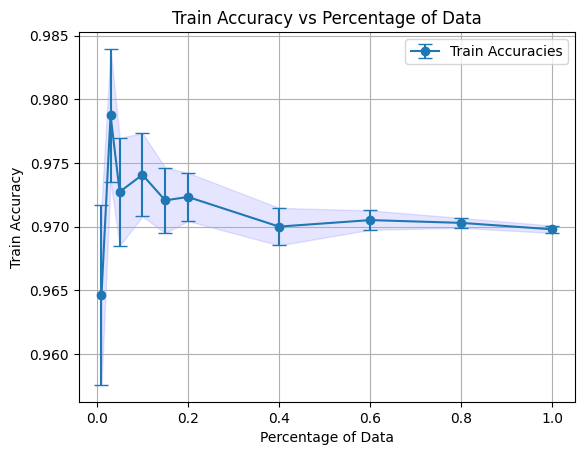

In [23]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.0001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Processing percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []
    
    for seed in tqdm(seed_set, desc=f'Running seeds for {perc} data', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

                # Copying model
        model_new = copy.deepcopy(model)

        # Calculate the output size from the pool layer dynamically
        # You would replace this with the actual size based on your model's architecture
        # model_new.fc_1 = nn.Linear(576, 128)
    
        # Reinitialize the second fully connected layer
        # model_new.fc_2 = nn.Linear(128, 5)
        
        # Ensure the softmax layer matches the number of classes (if used)
        model_new.softmax = nn.Softmax(dim=1)
        
        model_new.to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


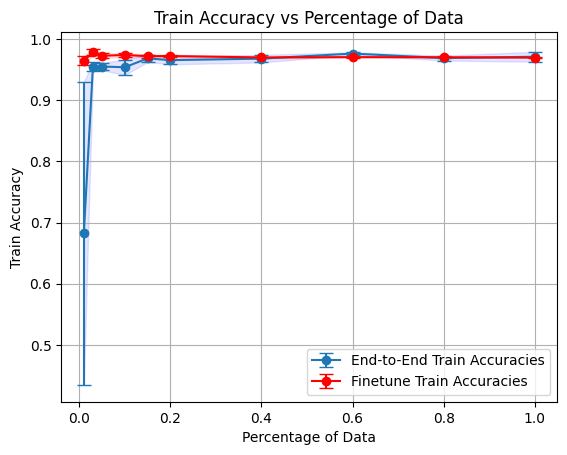

In [24]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

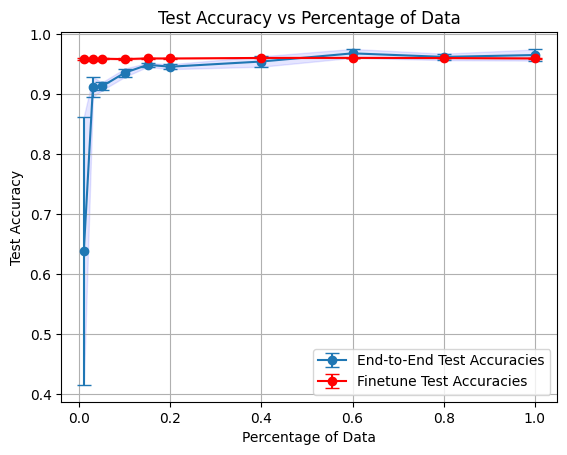

In [25]:
# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]

plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
data_to_save = {
    "results_test_finetune": results_test_finetune,
    "results_train_finetune": results_train_finetune,
    "epochs_taken_finetune": epochs_taken_finetune,
    
    "results_test": results_test,
    "results_train": results_train,
    "epochs_taken": epochs_taken
}

# Assuming data_to_save from the previous code
with open("data.json", "w") as file:
    json.dump(data_to_save, file)

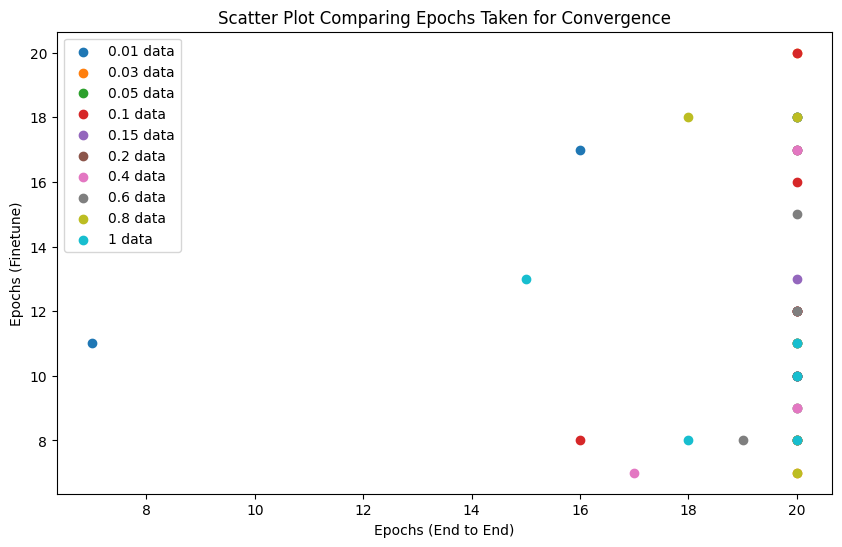

In [27]:
plt.figure(figsize=(10, 6))

for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()

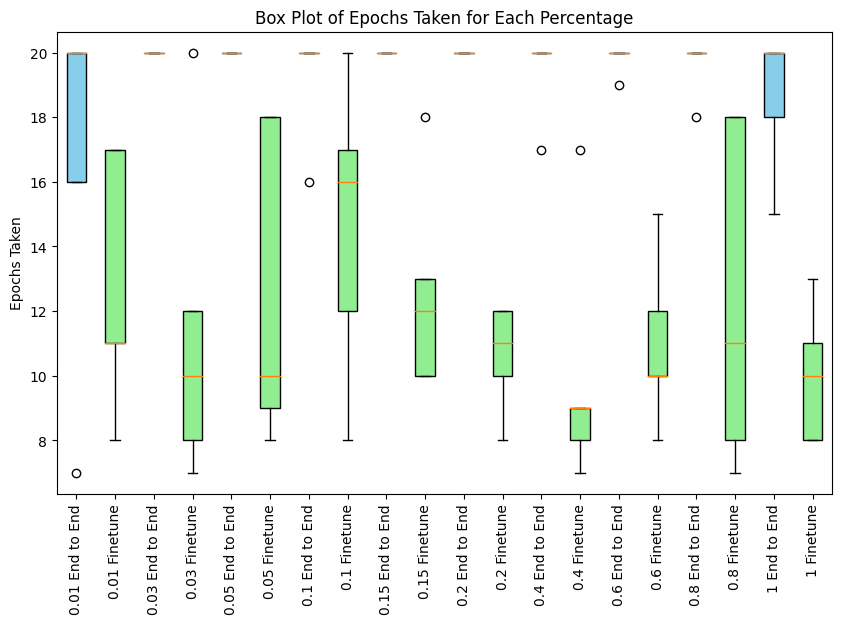

In [28]:
# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
